# This script is for multilayer/stacked RNN-GRU for training and testing






In [1]:
########################### 
# defining the Neural Network parameters
country='US'
eps=20
# do not have to change these values
hidden_size=300 #[20, 50, 100, 150, 200, 250, 300]
num_layers=2 #[1 2 3 4 5]
lr=0.00001 #[0.1, 0.01, 0.001, 0.0001, 0.00001]
window_size = 30
real_future = 60 
input_size=1 
output_size=1

In [2]:
# importing models, warnings and visualization libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
print('cuda' if torch.cuda.is_available() else cpu) 

cuda


In [3]:
# data loading and preprocessing
file_name='time_series_covid19_confirmed_global.csv'
data = pd.read_csv(file_name)
data = data.drop(['Province/State','Lat','Long'], axis = 1)
data = data[data['Country/Region'] == country]
data = pd.DataFrame(data = data.T)
data['total']=data.sum(axis=1)
day_date=pd.to_datetime(data.index[1:])
y_org=data[data.columns[1]][1:].values.astype(float)
x=np.arange(0,len(y_org))
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(y_org.reshape(-1, 1))
y_org

array([1.000000e+00, 1.000000e+00, 2.000000e+00, 2.000000e+00,
       5.000000e+00, 5.000000e+00, 5.000000e+00, 5.000000e+00,
       5.000000e+00, 7.000000e+00, 8.000000e+00, 8.000000e+00,
       1.100000e+01, 1.100000e+01, 1.100000e+01, 1.100000e+01,
       1.100000e+01, 1.100000e+01, 1.100000e+01, 1.100000e+01,
       1.200000e+01, 1.200000e+01, 1.300000e+01, 1.300000e+01,
       1.300000e+01, 1.300000e+01, 1.300000e+01, 1.300000e+01,
       1.300000e+01, 1.300000e+01, 1.500000e+01, 1.500000e+01,
       1.500000e+01, 1.500000e+01, 1.500000e+01, 1.500000e+01,
       1.600000e+01, 1.600000e+01, 2.400000e+01, 3.000000e+01,
       5.300000e+01, 7.300000e+01, 1.040000e+02, 1.740000e+02,
       2.220000e+02, 3.370000e+02, 4.510000e+02, 5.190000e+02,
       7.110000e+02, 1.109000e+03, 1.561000e+03, 2.157000e+03,
       2.870000e+03, 2.968000e+03, 4.360000e+03, 6.141000e+03,
       8.917000e+03, 1.415700e+04, 1.947900e+04, 2.582500e+04,
       3.376100e+04, 4.385000e+04, 5.411200e+04, 6.6055

In [4]:
# Define a test size and creating train and test sets
test_size = 14
train_set = y[:-test_size]
test_set = y[-test_size:]
train_set_x = x[:-test_size]
test_set_x = x[-test_size:]

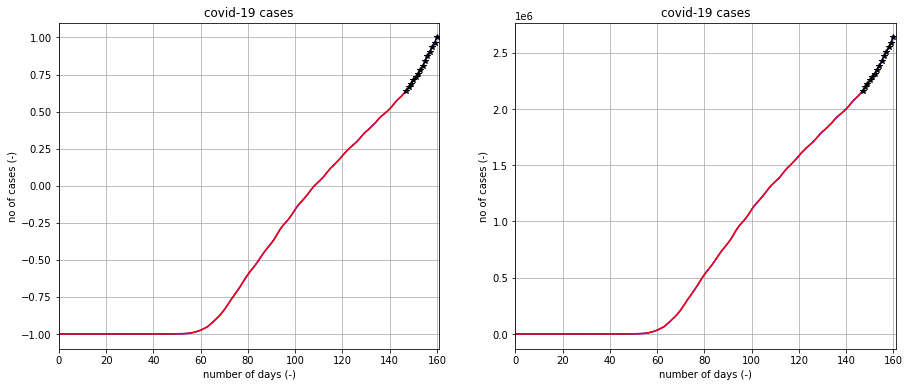

In [5]:
# data visualization to check the outliers
fig = plt.figure(figsize=(15,6))
plt.subplot(122)
plt.subplot(1,2,1)
#plt.figure(figsize=(12,4))
plt.title('covid-19 cases')
plt.ylabel('no of cases (-)')
plt.xlabel('number of days (-)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlim(0,len(y_org))
plt.plot(x,y,'-b')
plt.plot(train_set_x, train_set, 'r')
plt.plot(test_set_x,test_set, '*k')
#################################################################
plt.subplot(1,2,2)
#plt.figure(figsize=(6,6))
plt.title('covid-19 cases')
plt.ylabel('no of cases (-)')
plt.xlabel('number of days (-)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xlim(0,len(y_org))
y_total=scaler.inverse_transform(y)
plt.plot(x,y_total,'-b')
train_set_y=scaler.inverse_transform(train_set)                         
plt.plot(train_set_x, train_set_y, 'r')
test_set_y=scaler.inverse_transform(test_set)
plt.plot(test_set_x,test_set_y, '*k')
warnings.filterwarnings(action='once')

In [6]:
# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Multilayer GRU

In [7]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Add an GRU layer:
        self.GRU = nn.GRU(self.input_size,self.hidden_size,self.num_layers)

        #Add a fully-connected layer:
        self.linear = nn.Linear(self.hidden_size, output_size)
                
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(self.num_layers,1,self.hidden_size).cuda(),
                       torch.zeros(self.num_layers,1,self.hidden_size).cuda())
                       
    def forward(self, seq):
        gru_out, self.hidden = self.GRU(seq.view(len(seq), 1,-1))
        pred = self.linear(gru_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [8]:
# implementing Adam optimizer
torch.manual_seed(101)
model = GRU(input_size, hidden_size, output_size, num_layers).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
#optimizer = torch.optim.SGD(model.parameters(), lr)
model

GRU(
  (GRU): GRU(1, 300, num_layers=2)
  (linear): Linear(in_features=300, out_features=1, bias=True)
)

In [9]:
#function to claculate the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

   900
270000
   900
   900
270000
270000
   900
   900
   300
     1
______
814801


##Training and simultaneous validation with known data and simultaneous plotting to see the comparision

Epoch:                    1 Loss: 0.36931479
Loss on test predictions: 0.6842848658561707


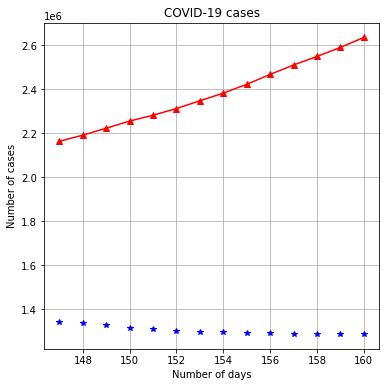

Epoch:                    2 Loss: 0.36333668
Loss on test predictions: 0.7509746551513672


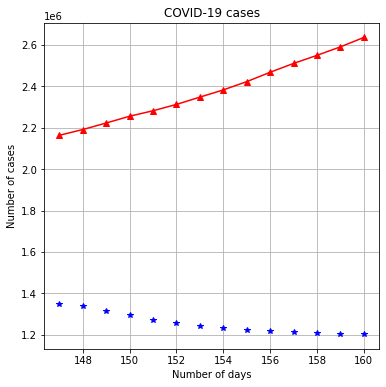

Epoch:                    3 Loss: 0.29484159
Loss on test predictions: 0.7469465136528015


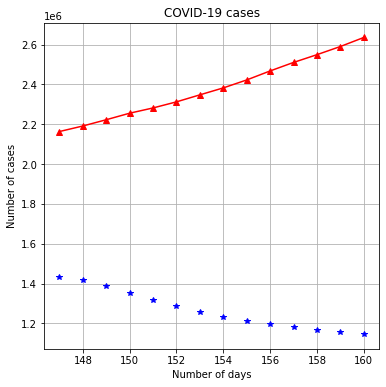

Epoch:                    4 Loss: 0.15791124
Loss on test predictions: 0.5288707613945007


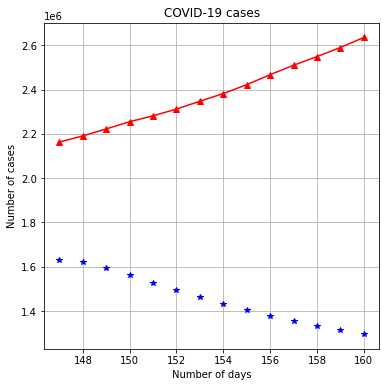

Epoch:                    5 Loss: 0.05496792
Loss on test predictions: 0.24922335147857666


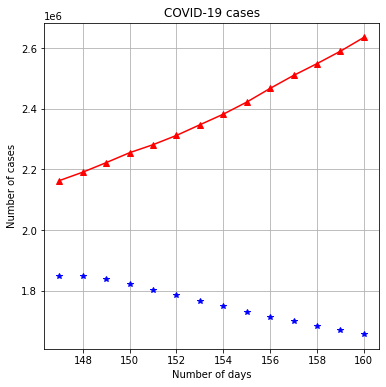

Epoch:                    6 Loss: 0.01260319
Loss on test predictions: 0.09062767028808594


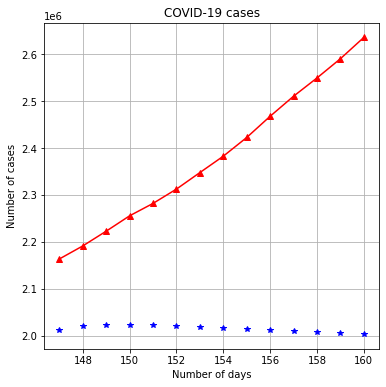

Epoch:                    7 Loss: 0.00273803
Loss on test predictions: 0.03887900710105896


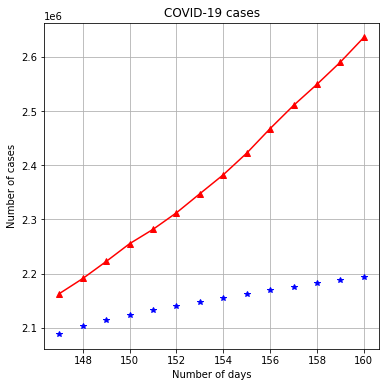

Epoch:                    8 Loss: 0.00119449
Loss on test predictions: 0.027400510385632515


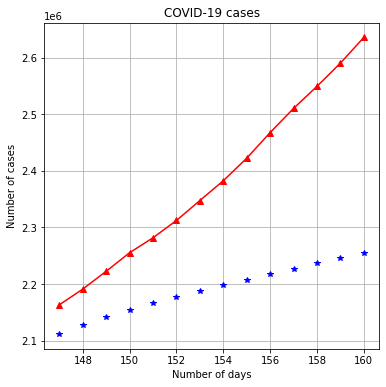

Epoch:                    9 Loss: 0.00099581
Loss on test predictions: 0.02558148093521595


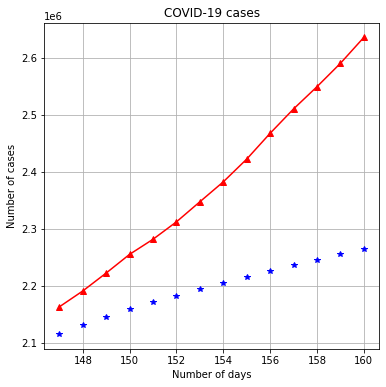

Epoch:                   10 Loss: 0.00099365
Loss on test predictions: 0.025478491559624672


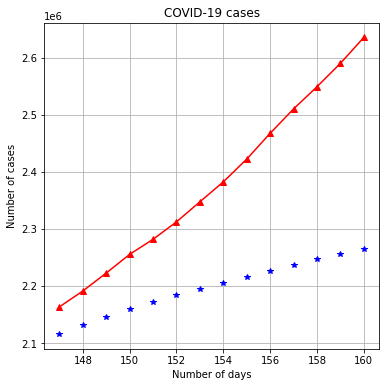

Epoch:                   11 Loss: 0.00100713
Loss on test predictions: 0.02550419792532921


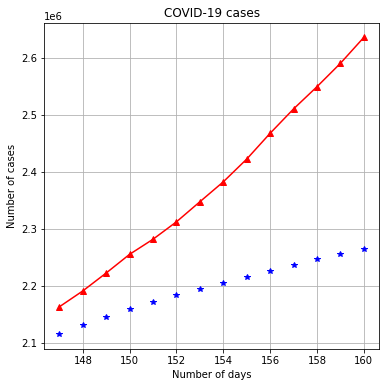

Epoch:                   12 Loss: 0.00101137
Loss on test predictions: 0.025434283539652824


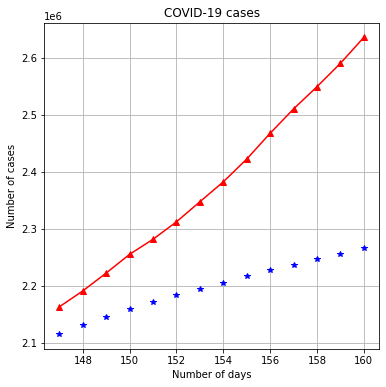

Epoch:                   13 Loss: 0.00100559
Loss on test predictions: 0.02526457980275154


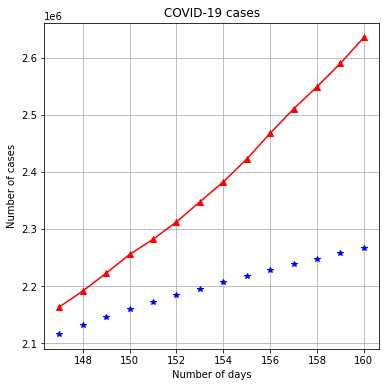

Epoch:                   14 Loss: 0.00099168
Loss on test predictions: 0.025014029815793037


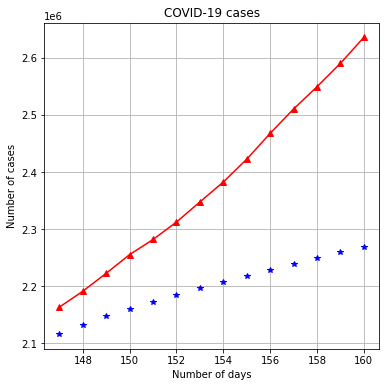

Epoch:                   15 Loss: 0.00097141
Loss on test predictions: 0.024699820205569267


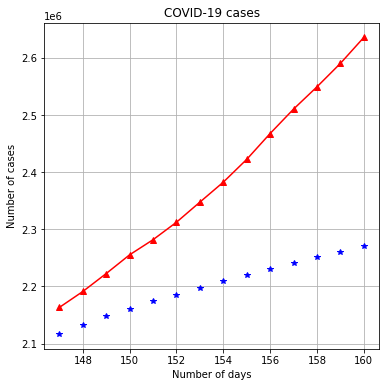

Epoch:                   16 Loss: 0.00094628
Loss on test predictions: 0.024336012080311775


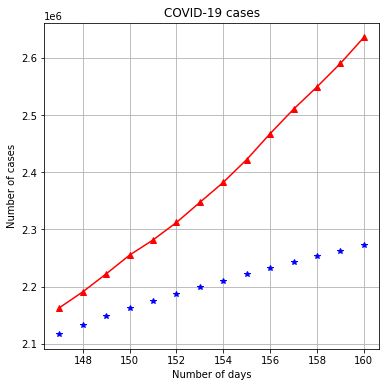

Epoch:                   17 Loss: 0.00091750
Loss on test predictions: 0.02393396757543087


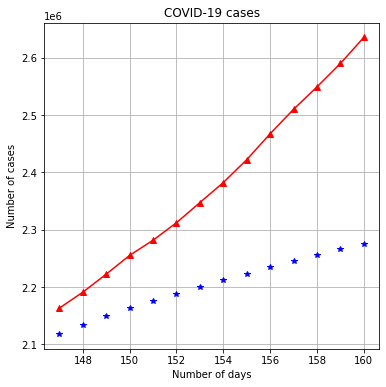

Epoch:                   18 Loss: 0.00088607
Loss on test predictions: 0.02350291796028614


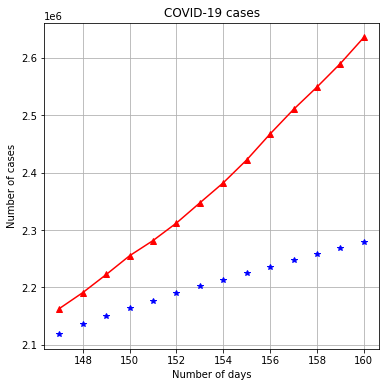

Epoch:                   19 Loss: 0.00085280
Loss on test predictions: 0.023050392046570778


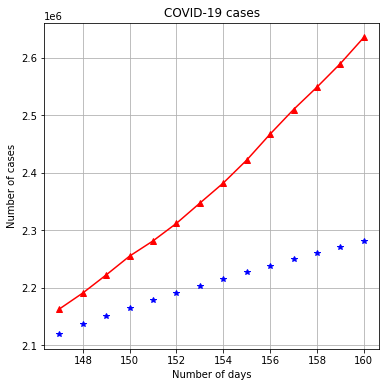

Epoch:                   20 Loss: 0.00081836
Loss on test predictions: 0.022582722827792168


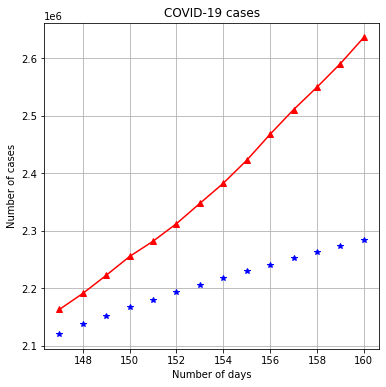


Duration: 12 seconds


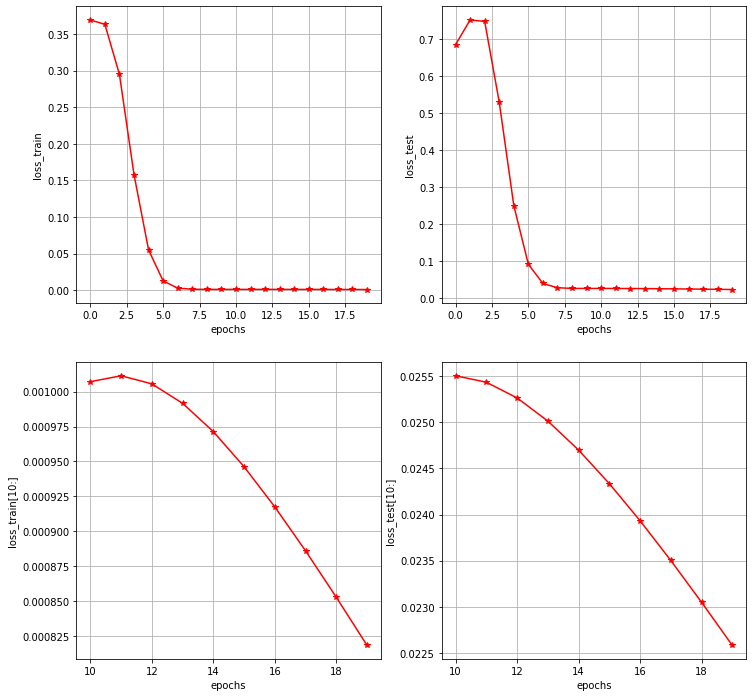

In [10]:
start_time = time.time()
epochs_test = eps
future_test = len(test_set)
# Define a window size (defined with model parameters)
# Convert train_norm from an array to a tensor
train_set = torch.FloatTensor(train_set).view(-1).cuda()
y = torch.FloatTensor(y).view(-1)
# Apply the input_data function to train_norm
train_data = input_data(train_set,window_size)
loss_train=[]
loss_test=[]
for epoch in range(epochs_test):
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                        torch.zeros(model.num_layers,1,model.hidden_size).cuda())
        y_pred = model(seq)
        # y_pred = y_pred.cpu().var.detach().numpy()
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1:20} Loss: {loss.item():10.8f}')
    loss_train.append(loss.item())    
    # Add the last window of training values to the list of predictions
    preds = train_set[-window_size:].tolist()
    for i in range(future_test):
        seq = torch.FloatTensor(preds[-window_size:]).cuda()
        with torch.no_grad():
            model.hidden = (torch.zeros(model.num_layers,1,model.hidden_size).cuda(),
                            torch.zeros(model.num_layers,1,model.hidden_size).cuda())
            preds.append(model(seq).item())    
    true_predictions = scaler.inverse_transform(np.array(preds[-future_test:]).reshape(-1, 1))
    loss1 = criterion(torch.tensor(preds[-future_test:]),(y[-future_test:]))
    print(f'Loss on test predictions: {loss1}')
    loss_test.append(loss1.item())
    # print training result
    # Plot the end of the graph
    fig1 = plt.figure(figsize=(6,6))
    plt.title('COVID-19 cases')
    plt.ylabel('Number of cases')
    plt.xlabel('Number of days')
    plt.grid(True)
    # Select the end of the graph with slice notation:
    #plt.plot(df.cases[:],'-r')
    plt.plot(x[-future_test:],y_org[-future_test:], '-^r')
    plt.plot(test_set_x,true_predictions, '*b')
    plt.show()
#     fig = plt.figure(figsize=(6,6))
#     plt.plot(test_set_x,test_set, '-^r')
#     plt.plot(test_set_x,np.asarray(preds[-future:]), '*b')
#     plt.title('COVID-19 cases_norm')
#     plt.ylabel('Number of cases_norm')
#     plt.grid(True)
#     plt.show()
fig_name1='GRU_TTpred_ep'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'_ws_'+str(window_size)+'.png'
fig1.savefig(fig_name1, bbox_inches='tight')
warnings.filterwarnings(action='ignore')    
fig2 = plt.figure(figsize=(12,12))
plt.subplot(224)
plt.subplot(2,2,1)
plt.plot(np.arange(epochs_test),(loss_train),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_train')
plt.subplot(2,2,2)
plt.plot(np.arange(epochs_test),(loss_test),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_test')
plt.subplot(2,2,3)
plt.plot(np.arange(10, epochs_test),(loss_train[10:]),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_train[10:]')
plt.subplot(2,2,4)
plt.plot(np.arange(10, epochs_test),(loss_test[10:]),'-*r')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss_test[10:]')
fig_name2='GRU_TTloss_ep'+str(eps)+'_hs_'+str(hidden_size)+'_nl_'+str(num_layers)+'_lr_'+str(lr)+'_ws_'+str(window_size)+'.png'
fig2.savefig(fig_name2, bbox_inches='tight')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')
v1=day_date
v2=y_org
v3=x[-future_test:]
v4=y_org[-future_test:]
v5=test_set_x
v6=true_predictions.ravel() 
v7=np.arange(epochs_test)
v8=loss_train
v9=loss_test
data2save1=pd.DataFrame(data=[v1,v2,v3,v4,v5,v6,v7,v8,v9])
data2save1=data2save1.T
data2save1.columns = ['date_org','reported_data','test_data_NumX','Test_data_y_reported','test_pred_x','test_pred_y','epcohs_x','loss_trian','loss_test']
data2save1.to_csv(country+'_GRU_TT_'+file_name[20:-4]+fig_name2[1:-4]+'.csv', index=0)